In [1]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import random
from scipy import stats
from scipy import fft
import random
import pywt.data
from PIL import Image
import pandas as pd
import seaborn as sns
import os
import pickle

In [2]:
# assign directory
ROOT_DIR = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
data_dir = ROOT_DIR + 'Data/Panoptic Argiculture 2/Toy dataset - rgb cleaned'
 
# iterate over files in that directory
file_list = [os.path.join(data_dir, filename) for filename in os.listdir(data_dir)]
file_names = os.listdir(data_dir)
n = len(file_list)

In [3]:
def getIndexDF(image, no_zero =False):
    x_freqs = fft.fftfreq(image.shape[0])
    y_freqs = fft.fftfreq(image.shape[1])
    coord_df = pd.DataFrame()
    coord_df["index_coords"] = [(x,y) for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_index"] = [x for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_index"] = [y for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["x_freq"] = [x_freqs[x] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["y_freq"] = [y_freqs[y] for x in np.arange(image.shape[0]) for y in np.arange(image.shape[0])]
    coord_df["magnitude"] = np.sqrt(coord_df["x_freq"] ** 2 + coord_df["y_freq"] **2)
    coord_df = coord_df.set_index(["index_coords"])
    coord_df = coord_df[(coord_df["x_freq"] >= 0 )& (coord_df["y_freq"] >= 0)]
    if no_zero:
        coord_df = coord_df[(coord_df["x_freq"] != 0 )| (coord_df["y_freq"] != 0)]
    return coord_df

In [4]:
def convert_fourier_list(folder_dir, c):
    file_list = [os.path.join(folder_dir, filename) for filename in os.listdir(folder_dir)]
    image = np.array(Image.open(file_list[0]).convert('L'))
    coord_df = getIndexDF(image, no_zero =False).sort_values(["magnitude"])
    x = coord_df["x_index"].to_numpy()
    y = coord_df["y_index"].to_numpy()
    magnitudes = coord_df["magnitude"]
    freq_arr = []
    mag_arr =  []
    for k in range(len(file_list)):
        if c >= 3:
            image = np.array(Image.open(file_list[k]).convert('L'))
        else:
            image = np.array(Image.open(file_list[k]))[:,:,c]
        transformed = np.array(fft.fft2(image))
        freq_arr.append(transformed[tuple(x), tuple(y)])
        mag_arr.append(magnitudes)
    sample = np.concatenate(np.array(freq_arr).T)
    mag_flat = np.concatenate(np.array(mag_arr).T)
    return sample, mag_flat

In [5]:
def recursive_split(freqs, mags, threshold =0.05, max_depth = 5, presplit = 0):
    magnitude_splits = []
    def recursive_helper(freqs, mags, magnitude_splits, depth, presplit):
        if depth > 0 and mags[0] != mags[-1]:
            n = (mags[-1] + mags[0])/2
            idx = np.argmax(mags>n)
            if presplit > 0:
                stat = threshold + 1
            else:
                first_sample = np.concatenate([np.real(freqs[:idx]),np.imag(freqs[:idx])])
                second_sample = np.concatenate([np.real(freqs[idx:]),np.imag(freqs[idx:])])
                stat = stats.ks_2samp(first_sample, second_sample).statistic
            if stat > threshold:
                magnitude_splits.append(n)
                recursive_helper(freqs[:idx], mags[:idx], magnitude_splits, depth-1, max(presplit-1, 0))
                recursive_helper(freqs[idx:], mags[idx:], magnitude_splits, depth-1, max(presplit-1, 0))
        elif mags[0] == mags[-1]:
            print(f"Both Endpoints Are The Same {mags[0]} and {mags[-1]} Recursion Depth of {max_depth - depth}")
        elif depth == 0:
            print(f"Recursion Depth Exceeded Endpoints are {mags[0]} and {mags[-1]}")
    recursive_helper(freqs, mags, magnitude_splits, max_depth, presplit)
    return magnitude_splits





In [8]:
def convert_to_fourier_basis(folder_dir, color, threshold =0.05, max_depth = 5, presplit = 0, split_list = None):
    color_dict = {"Red":0, "Green":1, "Blue":2, "Gray":3, "Infrared": 4}
    c = color_dict[color]
    freqs, mags = convert_fourier_list(folder_dir, c)
    df = pd.DataFrame(columns=["Band", "Channel", "Magnitude Endpoints","Unique Magnitudes", "Data"])

    if split_list == None:
        mag_splits = recursive_split(freqs, mags, threshold, max_depth, presplit)
    else:
        mag_splits = split_list
    
    sorted_mag_split = np.sort(mag_splits)
    print(sorted_mag_split)
    prev = 0
    for i in range(len(mag_splits)):
        next_idx = np.argmax(mags>sorted_mag_split[i])
        next_freqs = np.concatenate([np.real(freqs[prev:next_idx]),np.imag(freqs[prev:next_idx])])
        num_mags = len(np.unique(mags[prev:next_idx]))
        mag_endpoints = (min(mags[prev:next_idx]), max(mags[prev:next_idx]))

        df.loc[len(df.index)] = [i+1, color, mag_endpoints, num_mags, next_freqs]
        prev = next_idx

    return df

In [9]:
red_converted = convert_to_fourier_basis(data_dir, "Red", threshold =0.02, max_depth = 9, presplit= 2)
red_converted["Number of Coefficents"] = red_converted["Data"].apply(lambda x:len(x))/(2 *n)
red_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.01188039556698871
Recursion Depth Exceeded Endpoints are 0.012352647110032733 and 0.013101960805662831
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01207525 0.01357721 0.01644257 0.02194551 0.02741871
 0.03299406 0.04398869 0.05497586 0.06602095 0.08802615 0.11006022
 0.13206901 0.15406518 0.17606856 0.19815606 0.22015294 0.24214621
 0.26415428 0.28614297 0.30814661 0.35217232 0.44020209 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Red,"(0.0, 0.0)",1,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",1.0
1,2,Red,"(0.001953125, 0.001953125)",1,"[-12974.592655331986, -45660.77029153175, -54....",2.0
2,3,Red,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14184.106611974297, -18281.401770997843, 1045...",1.0
3,4,Red,"(0.00390625, 0.004367320268554277)",2,"[-3753.6335671811394, 4839.172219592722, -1538...",4.0
4,5,Red,"(0.005524271728019903, 0.006176323555016366)",3,"[2394.852349787814, 1147.5644067726053, 6912.6...",5.0
5,6,Red,"(0.007042092334890604, 0.0078125)",2,"[3043.671075303161, -9657.656023175681, -3985....",4.0
6,7,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997....",13.0
7,8,Red,"(0.011048543456039806, 0.01188039556698871)",4,"[-888.7412795504757, -2005.635692094722, 3037....",7.0
8,9,Red,"(0.012352647110032733, 0.013101960805662831)",3,"[-1509.9420581538498, 1127.5971491489754, -275...",6.0
9,10,Red,"(0.013671875, 0.016105881350068987)",9,"[162.45796669120477, 460.93597734919894, 7253....",21.0


In [10]:
red_converted = convert_to_fourier_basis(data_dir, "Red", threshold =0.02, max_depth = 9, presplit= 0)
red_converted["Number of Coefficents"] = red_converted["Data"].apply(lambda x:len(x))/(2 *n)
red_converted

Both Endpoints Are The Same 0.0 and 0.0 Recursion Depth of 9
Both Endpoints Are The Same 0.001953125 and 0.001953125 Recursion Depth of 9
Both Endpoints Are The Same 0.0027621358640099515 and 0.0027621358640099515 Recursion Depth of 9
Recursion Depth Exceeded Endpoints are 0.00390625 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.006176323555016366
Recursion Depth Exceeded Endpoints are 0.007042092334890604 and 0.0078125
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.01188039556698871
Recursion Depth Exceeded Endpoints are 0.012352647110032733 and 0.013101960805662831
[0.00097656 0.00218366 0.00356473 0.00525895 0.00666839 0.00802109
 0.0109183  0.01207525 0.01357721 0.01644257 0.02194551 0.02741871
 0.03299406 0.04398869 0.05497586 0.06602095 0.08802615 0.11006022
 0.13206901 0.15406518 0.17606856 0.19815606 0.22015294 0.24214621
 0.26415428 0.28614297 0.30814661 0.35217232 0.44020209 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Red,"(0.0, 0.0)",1,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",1.0
1,2,Red,"(0.001953125, 0.001953125)",1,"[-12974.592655331986, -45660.77029153175, -54....",2.0
2,3,Red,"(0.0027621358640099515, 0.0027621358640099515)",1,"[14184.106611974297, -18281.401770997843, 1045...",1.0
3,4,Red,"(0.00390625, 0.004367320268554277)",2,"[-3753.6335671811394, 4839.172219592722, -1538...",4.0
4,5,Red,"(0.005524271728019903, 0.006176323555016366)",3,"[2394.852349787814, 1147.5644067726053, 6912.6...",5.0
5,6,Red,"(0.007042092334890604, 0.0078125)",2,"[3043.671075303161, -9657.656023175681, -3985....",4.0
6,7,Red,"(0.008052940675034493, 0.010517900013934578)",6,"[-534.6031491594214, 2111.2590249634395, -997....",13.0
7,8,Red,"(0.011048543456039806, 0.01188039556698871)",4,"[-888.7412795504757, -2005.635692094722, 3037....",7.0
8,9,Red,"(0.012352647110032733, 0.013101960805662831)",3,"[-1509.9420581538498, 1127.5971491489754, -275...",6.0
9,10,Red,"(0.013671875, 0.016105881350068987)",9,"[162.45796669120477, 460.93597734919894, 7253....",21.0


In [11]:
red_converted = convert_to_fourier_basis(data_dir, "Red", threshold =0.03, max_depth = 7)
red_converted["Number of Coefficents"] = red_converted["Data"].apply(lambda x:len(x))/(2 *n)
red_converted

Recursion Depth Exceeded Endpoints are 0.0 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.010517900013934578
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.016105881350068987
Recursion Depth Exceeded Endpoints are 0.016572815184059706 and 0.021836601342771385
[0.00525895 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869
 0.06602095 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428
 0.30814661 0.35217232 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Red,"(0.0, 0.004367320268554277)",5,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",8.0
1,2,Red,"(0.005524271728019903, 0.010517900013934578)",11,"[2394.852349787814, 1147.5644067726053, 6912.6...",22.0
2,3,Red,"(0.011048543456039806, 0.016105881350068987)",16,"[-888.7412795504757, -2005.635692094722, 3037....",34.0
3,4,Red,"(0.016572815184059706, 0.021836601342771385)",22,"[-322.77002216586715, -4455.769937760134, 868....",48.0
4,5,Red,"(0.02209708691207961, 0.03274034104343791)",53,"[103.10197120007294, -1145.0518648370926, 8918...",126.0
5,6,Red,"(0.03314563036811941, 0.043891025496570764)",72,"[-864.9050960310876, 1061.6123613126601, -41.9...",184.0
6,7,Red,"(0.044064508487025304, 0.06588721794309765)",193,"[157.9422440303229, -514.3966552350057, -2380....",506.0
7,8,Red,"(0.06608954810815872, 0.08797738773090007)",256,"[285.189278547575, 782.4394962705526, 2495.553...",712.0
8,9,Red,"(0.08808572096702875, 0.1320347170402779)",699,"[-3.865658678271032, -614.466830574006, -2277....",2018.0
9,10,Red,"(0.13207804736481807, 0.1760523083722651)",939,"[260.322307321434, -478.41288867354876, -1982....",2822.0


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents,Magnitude Length
0,1,Red,"(0.0, 0.004367320268554277)",5,"[77928.0, 460483.0, 365878.0, 230599.0, 284593...",8.0,0.004367
1,2,Red,"(0.005524271728019903, 0.010517900013934578)",11,"[2394.852349787814, 1147.5644067726053, 6912.6...",22.0,0.004994
2,3,Red,"(0.011048543456039806, 0.016105881350068987)",16,"[-888.7412795504757, -2005.635692094722, 3037....",34.0,0.005057
3,4,Red,"(0.016572815184059706, 0.021836601342771385)",22,"[-322.77002216586715, -4455.769937760134, 868....",48.0,0.005264
4,5,Red,"(0.02209708691207961, 0.03274034104343791)",53,"[103.10197120007294, -1145.0518648370926, 8918...",126.0,0.010643
5,6,Red,"(0.03314563036811941, 0.043891025496570764)",72,"[-864.9050960310876, 1061.6123613126601, -41.9...",184.0,0.010745
6,7,Red,"(0.044064508487025304, 0.06588721794309765)",193,"[157.9422440303229, -514.3966552350057, -2380....",506.0,0.021823
7,8,Red,"(0.06608954810815872, 0.08797738773090007)",256,"[285.189278547575, 782.4394962705526, 2495.553...",712.0,0.021888
8,9,Red,"(0.08808572096702875, 0.1320347170402779)",699,"[-3.865658678271032, -614.466830574006, -2277....",2018.0,0.043949
9,10,Red,"(0.13207804736481807, 0.1760523083722651)",939,"[260.322307321434, -478.41288867354876, -1982....",2822.0,0.043974


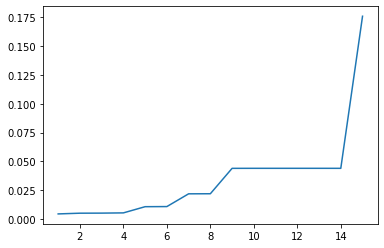

In [20]:
red_converted["Magnitude Length"] = red_converted["Magnitude Endpoints"].apply(lambda x: x[1] - x[0])
plt.plot(red_converted["Band"], red_converted["Magnitude Length"])
red_converted

In [12]:
green_converted = convert_to_fourier_basis(data_dir, "Green", threshold =0.03, max_depth = 7)
green_converted["Number of Coefficents"] = green_converted["Data"].apply(lambda x:len(x))/(2 *n)
green_converted

Recursion Depth Exceeded Endpoints are 0.0 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.010517900013934578
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.016105881350068987
Recursion Depth Exceeded Endpoints are 0.016572815184059706 and 0.021836601342771385
[0.00525895 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869
 0.06602095 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428
 0.30814661 0.35217232 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Green,"(0.0, 0.004367320268554277)",5,"[81813.0, 467467.0, 225750.0, 233632.0, 471000...",8.0
1,2,Green,"(0.005524271728019903, 0.010517900013934578)",11,"[1679.8198230852297, 2231.5487585676647, 3101....",22.0
2,3,Green,"(0.011048543456039806, 0.016105881350068987)",16,"[-407.11342573213653, -2893.7565435238716, -91...",34.0
3,4,Green,"(0.016572815184059706, 0.021836601342771385)",22,"[-469.79202908560893, -4379.650245812762, -358...",48.0
4,5,Green,"(0.02209708691207961, 0.03274034104343791)",53,"[-66.7249692195249, -609.1047149455238, 3210.8...",126.0
5,6,Green,"(0.03314563036811941, 0.043891025496570764)",72,"[-995.4688037614753, 1811.3615872326213, -891....",184.0
6,7,Green,"(0.044064508487025304, 0.06588721794309765)",193,"[165.29156549389097, -308.0901424070056, -864....",506.0
7,8,Green,"(0.06608954810815872, 0.08797738773090007)",256,"[150.2013859708636, 708.1310566401412, 1352.42...",712.0
8,9,Green,"(0.08808572096702875, 0.1320347170402779)",699,"[-41.104003603022115, -386.01111361734536, -11...",2018.0
9,10,Green,"(0.13207804736481807, 0.1760523083722651)",939,"[352.0690707098275, -496.1685151746119, -2218....",2822.0


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents,Magnitude Length
0,1,Green,"(0.0, 0.004367320268554277)",5,"[81813.0, 467467.0, 225750.0, 233632.0, 471000...",8.0,0.004367
1,2,Green,"(0.005524271728019903, 0.010517900013934578)",11,"[1679.8198230852297, 2231.5487585676647, 3101....",22.0,0.004994
2,3,Green,"(0.011048543456039806, 0.016105881350068987)",16,"[-407.11342573213653, -2893.7565435238716, -91...",34.0,0.005057
3,4,Green,"(0.016572815184059706, 0.021836601342771385)",22,"[-469.79202908560893, -4379.650245812762, -358...",48.0,0.005264
4,5,Green,"(0.02209708691207961, 0.03274034104343791)",53,"[-66.7249692195249, -609.1047149455238, 3210.8...",126.0,0.010643
5,6,Green,"(0.03314563036811941, 0.043891025496570764)",72,"[-995.4688037614753, 1811.3615872326213, -891....",184.0,0.010745
6,7,Green,"(0.044064508487025304, 0.06588721794309765)",193,"[165.29156549389097, -308.0901424070056, -864....",506.0,0.021823
7,8,Green,"(0.06608954810815872, 0.08797738773090007)",256,"[150.2013859708636, 708.1310566401412, 1352.42...",712.0,0.021888
8,9,Green,"(0.08808572096702875, 0.1320347170402779)",699,"[-41.104003603022115, -386.01111361734536, -11...",2018.0,0.043949
9,10,Green,"(0.13207804736481807, 0.1760523083722651)",939,"[352.0690707098275, -496.1685151746119, -2218....",2822.0,0.043974


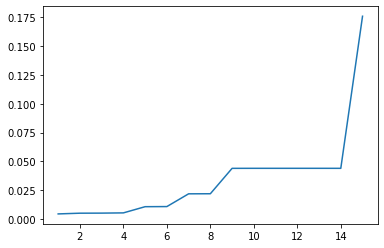

In [21]:
green_converted["Magnitude Length"] = green_converted["Magnitude Endpoints"].apply(lambda x: x[1] - x[0])
plt.plot(green_converted["Band"], green_converted["Magnitude Length"])
green_converted

In [13]:
blue_converted = convert_to_fourier_basis(data_dir, "Blue", threshold =0.03, max_depth = 7)
blue_converted["Number of Coefficents"] = blue_converted["Data"].apply(lambda x:len(x))/(2 *n)
blue_converted

Recursion Depth Exceeded Endpoints are 0.0 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.010517900013934578
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.016105881350068987
Recursion Depth Exceeded Endpoints are 0.016572815184059706 and 0.021836601342771385
[0.00525895 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869
 0.06602095 0.08802615 0.11006022 0.13206901 0.15406518 0.17606856
 0.22015294 0.26415428 0.30814661 0.35217232 0.44020209 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Blue,"(0.0, 0.004367320268554277)",5,"[97520.0, 462386.0, 242847.0, 232402.0, 545272...",8.0
1,2,Blue,"(0.005524271728019903, 0.010517900013934578)",11,"[-2890.776799271239, 2008.4722622731708, 4178....",22.0
2,3,Blue,"(0.011048543456039806, 0.016105881350068987)",16,"[890.9303517748317, -2177.084315505193, 1404.6...",34.0
3,4,Blue,"(0.016572815184059706, 0.021836601342771385)",22,"[-652.6257027819677, -4610.299630287783, 3120....",48.0
4,5,Blue,"(0.02209708691207961, 0.03274034104343791)",53,"[-459.58992724394307, -975.1328161037195, 1781...",126.0
5,6,Blue,"(0.03314563036811941, 0.043891025496570764)",72,"[-1698.5432921280187, 1289.8493439212934, 3468...",184.0
6,7,Blue,"(0.044064508487025304, 0.06588721794309765)",193,"[-823.3355393168758, -461.7968883481693, -3763...",506.0
7,8,Blue,"(0.06608954810815872, 0.08797738773090007)",256,"[-63.7432101133749, 767.4343543439777, -56.139...",712.0
8,9,Blue,"(0.08808572096702875, 0.11000099875256815)",318,"[-326.1020266284386, -362.5179508809689, -2445...",912.0
9,10,Blue,"(0.11007033440316696, 0.1320347170402779)",381,"[376.61433353769985, 782.2855997381946, 332.50...",1106.0


In [14]:
gray_converted = convert_to_fourier_basis(data_dir, "Gray", threshold =0.03, max_depth = 7)
gray_converted["Number of Coefficents"] = gray_converted["Data"].apply(lambda x:len(x))/(2 *n)
gray_converted

Recursion Depth Exceeded Endpoints are 0.0 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.010517900013934578
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.016105881350068987
Recursion Depth Exceeded Endpoints are 0.016572815184059706 and 0.021836601342771385
[0.00525895 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869
 0.06602095 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428
 0.30814661 0.35217232 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Gray,"(0.0, 0.004367320268554277)",5,"[80367.0, 464026.0, 265558.0, 232272.0, 394565...",8.0
1,2,Gray,"(0.005524271728019903, 0.010517900013934578)",11,"[1987.4616521549997, 1684.7761794782002, 4358....",22.0
2,3,Gray,"(0.011048543456039806, 0.016105881350068987)",16,"[-596.3965045249346, -2458.981803649216, 759.5...",34.0
3,4,Gray,"(0.016572815184059706, 0.021836601342771385)",22,"[-452.29783604268306, -4407.522572694999, 691....",48.0
4,5,Gray,"(0.02209708691207961, 0.03274034104343791)",53,"[13.158330891475558, -900.1066326574236, 4647....",126.0
5,6,Gray,"(0.03314563036811941, 0.043891025496570764)",72,"[-938.6251523609274, 1439.2322300920237, -94.6...",184.0
6,7,Gray,"(0.044064508487025304, 0.06588721794309765)",193,"[141.7774212615704, -402.00865686483013, -1703...",506.0
7,8,Gray,"(0.06608954810815872, 0.08797738773090007)",256,"[203.92940564490297, 743.1357966963146, 1659.3...",712.0
8,9,Gray,"(0.08808572096702875, 0.1320347170402779)",699,"[-0.8543177599976275, -479.4265829433799, -179...",2018.0
9,10,Gray,"(0.13207804736481807, 0.1760523083722651)",939,"[325.10705099183696, -488.86778843489867, -205...",2822.0


In [15]:
infra_dir = ROOT_DIR + 'Data/Panoptic Argiculture 2/Toy dataset - Near Infra Red'

In [16]:
infra_converted = convert_to_fourier_basis(data_dir, "Infrared", threshold =0.03, max_depth = 7)
infra_converted["Number of Coefficents"] = infra_converted["Data"].apply(lambda x:len(x))/(2 *n)
infra_converted

Recursion Depth Exceeded Endpoints are 0.0 and 0.004367320268554277
Recursion Depth Exceeded Endpoints are 0.005524271728019903 and 0.010517900013934578
Recursion Depth Exceeded Endpoints are 0.011048543456039806 and 0.016105881350068987
Recursion Depth Exceeded Endpoints are 0.016572815184059706 and 0.021836601342771385
[0.00525895 0.0109183  0.01644257 0.02194551 0.03299406 0.04398869
 0.06602095 0.08802615 0.13206901 0.17606856 0.22015294 0.26415428
 0.30814661 0.35217232 0.52825984]


,Band,Channel,Magnitude Endpoints,Unique Magnitudes,Data,Number of Coefficents
0,1,Infrared,"(0.0, 0.004367320268554277)",5,"[80367.0, 464026.0, 265558.0, 232272.0, 394565...",8.0
1,2,Infrared,"(0.005524271728019903, 0.010517900013934578)",11,"[1987.4616521549997, 1684.7761794782002, 4358....",22.0
2,3,Infrared,"(0.011048543456039806, 0.016105881350068987)",16,"[-596.3965045249346, -2458.981803649216, 759.5...",34.0
3,4,Infrared,"(0.016572815184059706, 0.021836601342771385)",22,"[-452.29783604268306, -4407.522572694999, 691....",48.0
4,5,Infrared,"(0.02209708691207961, 0.03274034104343791)",53,"[13.158330891475558, -900.1066326574236, 4647....",126.0
5,6,Infrared,"(0.03314563036811941, 0.043891025496570764)",72,"[-938.6251523609274, 1439.2322300920237, -94.6...",184.0
6,7,Infrared,"(0.044064508487025304, 0.06588721794309765)",193,"[141.7774212615704, -402.00865686483013, -1703...",506.0
7,8,Infrared,"(0.06608954810815872, 0.08797738773090007)",256,"[203.92940564490297, 743.1357966963146, 1659.3...",712.0
8,9,Infrared,"(0.08808572096702875, 0.1320347170402779)",699,"[-0.8543177599976275, -479.4265829433799, -179...",2018.0
9,10,Infrared,"(0.13207804736481807, 0.1760523083722651)",939,"[325.10705099183696, -488.86778843489867, -205...",2822.0


In [ ]:
pd.to_pickle(red_converted, ROOT_DIR + "red_pickle.pkl")